In [2]:
from gerrychain import updaters, Graph, constraints, GeographicPartition, proposals, tree, Election
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [3]:
graph = Graph.from_file("./VA_MUNI_DATA/va_precincts_all.shp")
print("Loaded graph")


/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(309, 320), (307, 320), (308, 309)}
  overlaps


Loaded graph


/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column G17DGOV!
  warnings.warn("NA values found in column {}!".format(column))
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column G16OHOR!
  warnings.warn("NA values found in column {}!".format(column))
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column notes!
  warnings.warn("NA values found in column {}!".format(column))
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/gerrychain/graph/graph.py:249: UserWarning: NA values found in column explain!
  warnings.warn("NA values found in column {}!".format(column))


In [4]:
print("Sample node data: ")
print(print(graph.nodes[0]))

Sample node data: 
{'boundary_node': False, 'area': 13171012.745632773, 'precinct': 'Titustown', 'locality': 'Norfolk', 'loc_prec': 'Norfolk Titustown', 'district': 'Congressional District 2', 'G18DHOR': '666.0', 'G18DSEN': '680.0', 'G18OHOR': '0.0', 'G18OSEN': '12.0', 'G18RHOR': '87.0', 'G18RSEN': '68.0', 'G17DGOV': '516.0', 'G17DLTG': '519.0', 'G17DATG': '510.0', 'G17DHOD': '533.0', 'G17RGOV': '54.0', 'G17RLTG': '63.0', 'G17RATG': '70.0', 'G17RHOD': '0.0', 'G17OHOD': '0.0', 'G17OGOV': '11.0', 'G16DPRS': '772.0', 'G16RPRS': '135.0', 'G16OPRS': '49.0', 'G16DHOR': '780.0', 'G16RHOR': '149.0', 'G16OHOR': '0.0', 'notes': None, 'explain': None, 'TOTPOP': 8728, 'WHITE': 3234, 'AMIN': 74, 'ASIAN': 213, 'NHPI': 27, 'OTHER': 311, '2MORE': 529, 'VAP': 5943, 'DLS_BVAP': 2237, 'DLS_NONB': 3706, 'DOJ_BVAP': 2237, 'DOJ_NONB': 3706, 'SENPER': 0.909, 'ATGperc': 0.879, 'geometry': <shapely.geometry.polygon.Polygon object at 0x10dced5c0>}
None


In [11]:
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
}

elections = [
    Election("PRES16", {"Democratic": "G16DPRS", "Republican": "G16RPRS"}),
]
election_updaters = {election.name: election for election in elections}

#fix strings
for n in graph.nodes():
    graph.nodes[n]["G16DPRS"] = float(graph.nodes[n]["G16DPRS"])
    graph.nodes[n]["G16RPRS"] = float(graph.nodes[n]["G16RPRS"])


my_updaters.update(election_updaters)

initial_partition = GeographicPartition(graph, assignment="district", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
num_districts = len(initial_partition)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [7]:
PERCENTS = []
counter = 0
for sample in range(0,1000):
    counter += 1
    if counter % 50 == 0:
        print(counter, end=" ")
    district = tree.bipartition_tree(graph, "TOTPOP", ideal_population, 0.02, 2)
    DEMVOTES = sum([float(graph.nodes[n]["G16DPRS"]) for n in district])
    REPVOTES = sum([float(graph.nodes[n]["G16RPRS"]) for n in district])
    PERCENTS.append(DEMVOTES/(DEMVOTES+REPVOTES))

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 

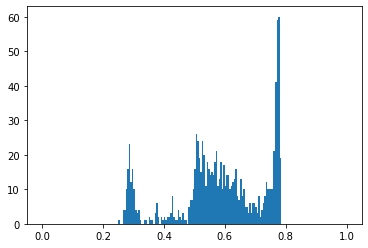

In [8]:
n_bins = 200
hist = plt.hist(PERCENTS, bins=np.linspace(0, 1, n_bins+1, endpoint=True))
pdf = [x/sum(PERCENTS) for x in hist[0]]

In [9]:
class one_district_pdf(st.rv_continuous):
    def _pdf(self,x):
        return pdf[np.digitize(x, np.linspace(0, 1, n_bins))-1]

PDF = one_district_pdf()

In [12]:
###MCMC time
vector = list(initial_partition["PRES16"].percents("Democratic"))
print("Starting vector: ", vector)

list_of_vector_dicts = []
counter = 0 
for step in range(0, 100000):
    [position1, position2] = np.random.choice(range(num_districts), size=2, replace=False)
    random01 = np.random.random()
    sum_of_positions = vector[position1]+vector[position2]
    proposal = [sum_of_positions*random01, sum_of_positions*(1-random01)]
    random_for_accept = np.random.random()
    alpha = PDF._pdf(proposal[0])*PDF._pdf(proposal[1])/(PDF._pdf(vector[position1])*PDF._pdf(vector[position2]))
    if (random_for_accept <= alpha):
        vector[position1] = proposal[0]
        vector[position2] = proposal[1]
    vector_dict = {x: sorted(vector)[x] for x in range(0, len(vector)) }
    counter += 1
    if counter > 1000:
        list_of_vector_dicts.append(vector_dict)
    
df = pd.DataFrame(list_of_vector_dicts)

Starting vector:  [0.4826194889664704, 0.6668046667948873, 0.36894194188675083, 0.2846913693840532, 0.43989904361649224, 0.779391438472787, 0.46527104962743665, 0.43358521400985345, 0.6121218230254158, 0.5499308429667163, 0.7087728990473056]


/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [13]:
df_real = pd.read_csv("./VA_PRES16/PRS16_2000.csv", header=None)
for x in range(4000,100001,2000):
    df_real = pd.concat([df_real, pd.read_csv(
        "./VA_PRES16/PRS16_{0}.csv".format(x), header=None)], ignore_index=True)

Done generating simulated boxplot...
Done generating real boxplot...


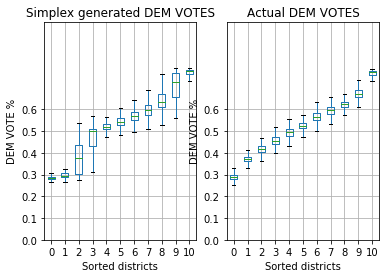

In [16]:
fig = plt.figure()
ax = plt.subplot(1,2,1)

# Draw 50% line
ax.set_title("Simplex generated DEM VOTES")
ax.set_ylabel("DEM VOTE %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# Draw boxplot
bp = df.boxplot(ax=ax, showfliers=False)
print("Done generating simulated boxplot...")

ax2 = plt.subplot(1,2,2)
bp_real = df_real.boxplot(ax=ax2, showfliers=False)
print("Done generating real boxplot...")
ax2.set_title("Actual DEM VOTES")
ax2.set_ylabel("DEM VOTE %")
ax2.set_xlabel("Sorted districts")
ax2.set_ylim(0, 1)
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])


# Annotate


plt.show()
fig.savefig("Comparing_simplex_to_actual_VA_demvotes.png")